In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
%matplotlib inline

In [2]:
!nvidia-smi

Tue Apr 13 13:18:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
data_folder = "/content/data_imp1.csv"

In [4]:
data = pd.read_csv(data_folder, index_col=0)
data = data.dropna()

In [5]:
# I will batch by sitename
sites = data['sitename'].unique()
sites_df = [data[data['sitename'] == site] for site in sites]
for i in range(len(sites_df)):
    sites_df[i]['date'] = pd.to_datetime(sites_df[i]['date'], format="%Y-%m-%d")
    sites_df[i] = sites_df[i].set_index("date")
    sites_df[i] = sites_df[i].drop(columns=["sitename"])
    sites_df[i] = sites_df[i].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
sites_df[0].columns

Index(['TA_F', 'SW_IN_F', 'LW_IN_F', 'VPD_F', 'PA_F', 'P_F', 'WS_F', 'USTAR',
       'CO2_F_MDS', 'GPP_NT_VUT_REF'],
      dtype='object')

In [6]:
# Normalize the columns
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'GPP_NT_VUT_REF':
          result[feature_name] = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()
    return result


In [7]:
sites_to_train = list(range(0, 71))
sites_to_train.remove(55)
site_to_test = [55]

train = [sites_df[i] for i in sites_to_train]
test = [sites_df[i] for i in site_to_test]

for i in range(len(train)):
    train[i] = normalize(train[i])

for i in range(len(test)):
    test[i] = normalize(test[i])

In [15]:
len(sites_df)

71

In [8]:
# Split data in batches
def make_batches(array_of_sites, n_cols=9):
    X_seqs = []
    y_seqs = []
    batches = []
    for site in array_of_sites:
        values = site.to_numpy()
        X_values = values[:, 0:n_cols]
        y_values = values[:, n_cols]

        X_seqs.append(X_values)
        y_seqs.append(y_values)

    return X_seqs, y_seqs

In [9]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.pad, dilation=dilation, **kwargs)
    
    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.conv.padding[0]]

class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation):
        super().__init__()
        self.conv = CausalConv1d(residual_channels, residual_channels, 2, dilation=dilation)
        self.conv_residual = nn.Conv1d(residual_channels, residual_channels, 1)
        self.conv_skip = nn.Conv1d(residual_channels, skip_channels, 1)

        self.gate_tanh = nn.Tanh()
        self.gate_sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = self.conv(x)

        gated_tanh = self.gate_tanh(output)
        gated_sigmoid = self.gate_sigmoid(output)
        gated = gated_tanh * gated_sigmoid

        output = self.conv_residual(gated)
        
        output += x

        # Skip connection
        skip = self.conv_skip(gated)

        return output, skip



class DensNet(torch.nn.Module):
    def __init__(self, channels):
        """
        The last network of WaveNet
        :param channels: number of channels for input and output
        :return:
        """
        super(DensNet, self).__init__()

        self.conv1 = torch.nn.Conv1d(channels, channels, 1)
        self.conv2 = torch.nn.Conv1d(channels, 1, 1)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        output = self.relu(x)
        output = self.conv1(output)
        output = self.relu(output)
        output = self.conv2(output)


        return output

class WaveNet(nn.Module):
    def __init__(self, n_dilations, n_residuals, in_channels, res_channels, device):
        super().__init__()
        self.causal = CausalConv1d(in_channels, res_channels, 2, 1)
        self.residual_blocks = [[] for i in range(n_dilations)]
        self.densenet = DensNet(9).to(device)
        self.n_residuals = n_residuals
        self.n_dilations = n_dilations

        for residual_id in range(n_residuals):
            for dilation_id in range(n_dilations):
                dilation = 2 ** dilation_id
                res_block = ResidualBlock(res_channels, in_channels, dilation).to(device)
                self.residual_blocks[dilation_id].append(res_block)

    def forward(self, x):
        skip_connections = []

        for dilation_id in range(self.n_dilations):
          output = self.causal(x)
          for block in self.residual_blocks[dilation_id]:
            output, skip = block(output)
            skip_connections.append(skip)

        output = torch.sum(torch.stack(skip_connections), dim=0)
        return self.densenet(output)

In [10]:
DEVICE = "cuda"
X_train, y_train = make_batches(train)
X_test, y_test = make_batches(test)

model = WaveNet(8, 4, 9, 128, DEVICE).to(DEVICE)
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(model.parameters())

In [11]:
train_losses = []
test_losses = []
for epoch in range(50):
    train_loss = 0.0
    test_loss = 0.0
    train_mse = 0.0
    test_mse = 0.0
    start = time.time()

    model.train()
    for (x, y) in zip(X_train, y_train):
        x = torch.FloatTensor(x).unsqueeze(0).permute(0, 2, 1).to(DEVICE)
        y = torch.FloatTensor(y).to(DEVICE)

        pred = model(x)

        pred = pred.squeeze()
        
        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mse += torch.mean((y - pred) ** 2)
    model.eval()
    with torch.no_grad():
        for (x, y) in zip(X_test, y_test):
            x = torch.FloatTensor(x).unsqueeze(0).permute(0, 2, 1).to(DEVICE)
            y = torch.FloatTensor(y).to(DEVICE)

            pred = model(x)

            pred = pred.squeeze()
            
            loss = criterion(pred, y)

            test_loss += loss.item()
            test_mse += torch.mean((y - pred) ** 2)
    end = time.time()
    dt = end - start
    print(f"Epoch: {epoch+1} ({dt}s)")
    print(f"Train loss: {train_loss / len(X_train)} | Test loss: {test_loss / len(X_test)}")
    print(f"Train MSE: {train_mse / len(X_train)} | Test MSE: {test_mse / len(X_test)}")

    # if len(test_losses) > 0 and test_loss / len(X_test) < min(test_losses):
    #     torch.save(model, f"model_{epoch+1}.pt")

    train_losses.append(train_loss / len(X_train))
    test_losses.append(test_loss / len(X_test))

Epoch: 1 (6.202147960662842s)
Train loss: 25.92808300767626 | Test loss: 5.633931636810303
Train MSE: 25.928085327148438 | Test MSE: 5.633931636810303
Epoch: 2 (5.883225917816162s)
Train loss: 14.445058471815926 | Test loss: 6.45123291015625
Train MSE: 14.445056915283203 | Test MSE: 6.45123291015625
Epoch: 3 (5.892391681671143s)
Train loss: 11.00548027583531 | Test loss: 7.581089973449707
Train MSE: 11.005477905273438 | Test MSE: 7.581089973449707
Epoch: 4 (5.898923635482788s)
Train loss: 10.182911457334246 | Test loss: 7.991119861602783
Train MSE: 10.18291187286377 | Test MSE: 7.991119861602783
Epoch: 5 (5.916281461715698s)
Train loss: 9.66337320463998 | Test loss: 8.316962242126465
Train MSE: 9.663375854492188 | Test MSE: 8.316962242126465
Epoch: 6 (5.900336027145386s)
Train loss: 9.342098539216177 | Test loss: 8.566524505615234
Train MSE: 9.342098236083984 | Test MSE: 8.566524505615234
Epoch: 7 (5.9292192459106445s)
Train loss: 9.138973222460066 | Test loss: 8.758718490600586
Train 

KeyboardInterrupt: ignored

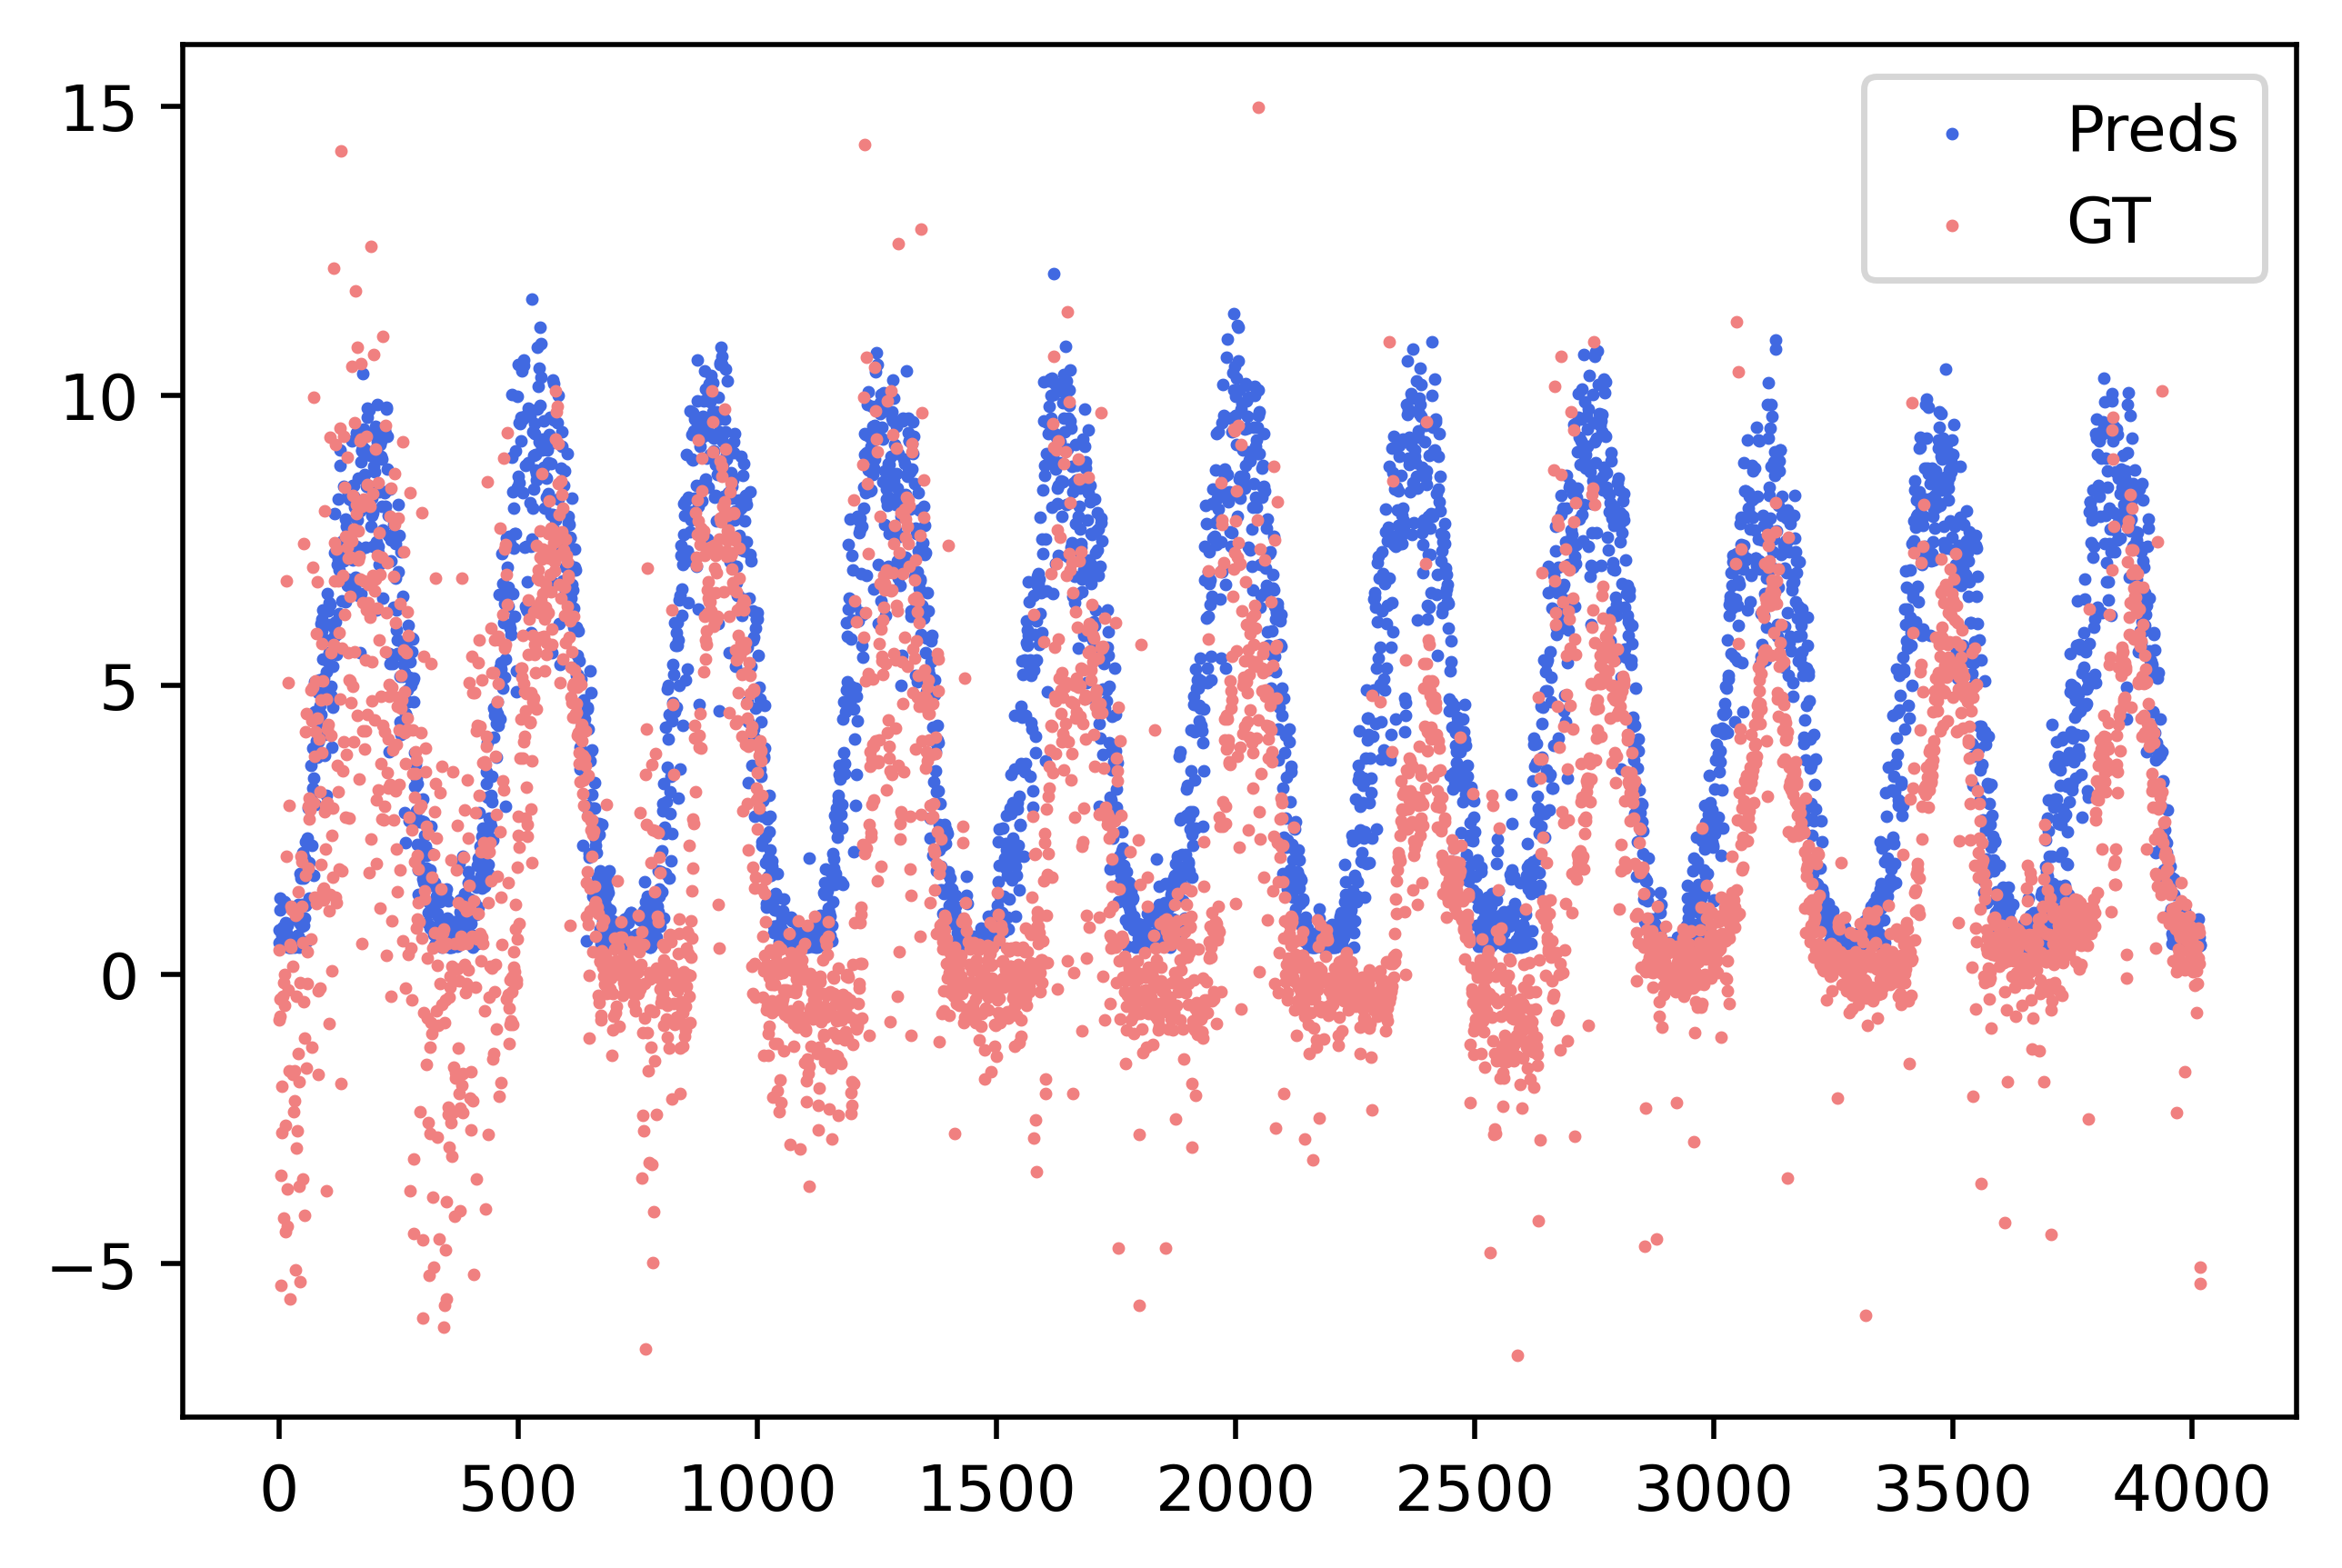

In [13]:
x = torch.FloatTensor(X_test[0]).unsqueeze(0).permute(0, 2, 1).to(DEVICE)
pred = model(x)

pred = pred.squeeze().detach().cpu().numpy()
y = y_test[0]

x_axis = range(len(y))
plt.ion()
plt.figure(dpi=500)
plt.scatter(x=x_axis, y=pred, s=1, label='Preds', c='royalblue')
plt.scatter(x=x_axis, y=y, s=1, label="GT", c='lightcoral')
plt.legend()
plt.show()

In [ ]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [ ]:
from sklearn.metrics import r2_score
# Leave-one-site-out CV
DEVICE = "cuda"

from tqdm import tqdm
cv_mse = []
cv_r2 = []
for s in tqdm(range(len(sites))):
  sites_to_train = list(range(0, 71))
  sites_to_train.remove(s)
  site_to_test = [s]

  train = [sites_df[i] for i in sites_to_train]
  test = [sites_df[i] for i in site_to_test]

  for i in range(len(train)):
    train[i] = normalize(train[i])

  for i in range(len(test)):
    test[i] = normalize(test[i])

  X_train, y_train = make_batches(train)
  X_test, y_test = make_batches(test)

  model = WaveNet(6, 4, 9, 128, DEVICE).to(DEVICE)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())

  train_losses = []
  test_losses = []
  r2 = []
  for epoch in range(50):
      train_loss = 0.0
      test_loss = 0.0
      train_mse = 0.0
      test_mse = 0.0
      start = time.time()

      model.train()
      for (x, y) in zip(X_train, y_train):
          x = torch.FloatTensor(x).unsqueeze(0).permute(0, 2, 1).to(DEVICE)
          y = torch.FloatTensor(y).to(DEVICE)

          pred = model(x)

          pred = pred.squeeze()
          
          optimizer.zero_grad()
          loss = criterion(pred, y)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_mse += torch.mean((y - pred) ** 2)
      model.eval()
      with torch.no_grad():
          for (x, y) in zip(X_test, y_test):
              x = torch.FloatTensor(x).unsqueeze(0).permute(0, 2, 1).to(DEVICE)
              y = torch.FloatTensor(y).to(DEVICE)

              pred = model(x)

              pred = pred.squeeze()
              
              loss = criterion(pred, y)

              test_loss += loss.item()
              test_mse += torch.mean((y - pred) ** 2)
              r2.append(r2_loss(pred,y))

      train_losses.append(train_loss / len(X_train))
      test_losses.append(test_loss / len(X_test))
  cv_r2.append(max(r2))
  cv_mse.append(min(test_losses))
  print("\n CV MSE cumulative mean: ", np.mean(cv_mse))
  print("\nCV R2 cumulative mean: ", np.mean(cv_r2))










  0%|          | 0/71 [00:00<?, ?it/s]








  1%|▏         | 1/71 [01:43<2:01:07, 103.82s/it]


 CV MSE cumulative mean:  30.304298400878906

CV R2 cumulative mean:  -0.431715726852417











  3%|▎         | 2/71 [03:27<1:59:17, 103.73s/it]


 CV MSE cumulative mean:  19.534292697906494

CV R2 cumulative mean:  -0.1149512529373169











  4%|▍         | 3/71 [05:10<1:57:26, 103.63s/it]


 CV MSE cumulative mean:  15.137058893839518

CV R2 cumulative mean:  -0.12398378054300944











  6%|▌         | 4/71 [06:53<1:55:33, 103.48s/it]


 CV MSE cumulative mean:  13.332563996315002

CV R2 cumulative mean:  0.04232111573219299











  7%|▋         | 5/71 [08:37<1:53:45, 103.42s/it]


 CV MSE cumulative mean:  11.99064359664917

CV R2 cumulative mean:  0.021570038795471192











  8%|▊         | 6/71 [10:21<1:52:11, 103.57s/it]


 CV MSE cumulative mean:  11.393929402033487

CV R2 cumulative mean:  0.018205076456069946











 10%|▉         | 7/71 [12:04<1:50:16, 103.38s/it]


 CV MSE cumulative mean:  10.615749767848424

CV R2 cumulative mean:  0.056807245526994975











 11%|█▏        | 8/71 [13:46<1:48:14, 103.08s/it]


 CV MSE cumulative mean:  9.98437386751175

CV R2 cumulative mean:  0.036634817719459534











 13%|█▎        | 9/71 [15:28<1:46:15, 102.84s/it]


 CV MSE cumulative mean:  9.888665676116943

CV R2 cumulative mean:  0.017579171392652724











 14%|█▍        | 10/71 [17:10<1:44:22, 102.66s/it]


 CV MSE cumulative mean:  9.499916458129883

CV R2 cumulative mean:  0.006826639175415039











 15%|█▌        | 11/71 [18:54<1:43:00, 103.01s/it]


 CV MSE cumulative mean:  9.019806601784445

CV R2 cumulative mean:  0.002771756865761497











 17%|█▋        | 12/71 [20:37<1:41:12, 102.93s/it]


 CV MSE cumulative mean:  9.209332784016928

CV R2 cumulative mean:  -0.033825298150380455











 18%|█▊        | 13/71 [22:18<1:38:59, 102.40s/it]


 CV MSE cumulative mean:  8.815092857067402

CV R2 cumulative mean:  0.018757723844968356











 20%|█▉        | 14/71 [24:00<1:37:05, 102.20s/it]


 CV MSE cumulative mean:  8.537530660629272

CV R2 cumulative mean:  0.0647924074104854











 21%|██        | 15/71 [25:42<1:35:26, 102.26s/it]


 CV MSE cumulative mean:  8.719392935434977

CV R2 cumulative mean:  0.09774140119552613











 23%|██▎       | 16/71 [27:24<1:33:43, 102.25s/it]


 CV MSE cumulative mean:  8.634167671203613

CV R2 cumulative mean:  0.12796418368816376











 24%|██▍       | 17/71 [29:07<1:32:08, 102.37s/it]


 CV MSE cumulative mean:  8.731552348417395

CV R2 cumulative mean:  0.14723259561202107











 25%|██▌       | 18/71 [30:50<1:30:27, 102.40s/it]


 CV MSE cumulative mean:  8.506720569398668

CV R2 cumulative mean:  0.15630827016300625











 27%|██▋       | 19/71 [32:32<1:28:36, 102.25s/it]


 CV MSE cumulative mean:  8.294941350033408

CV R2 cumulative mean:  0.17104724206422506











 28%|██▊       | 20/71 [34:13<1:26:41, 101.99s/it]


 CV MSE cumulative mean:  8.091315031051636

CV R2 cumulative mean:  0.19852792620658874











 30%|██▉       | 21/71 [35:54<1:24:47, 101.76s/it]


 CV MSE cumulative mean:  8.052903561365037

CV R2 cumulative mean:  0.22060892695472353











 31%|███       | 22/71 [37:35<1:22:50, 101.44s/it]


 CV MSE cumulative mean:  8.191594622351907

CV R2 cumulative mean:  0.23204140771519055











 32%|███▏      | 23/71 [39:16<1:21:00, 101.26s/it]


 CV MSE cumulative mean:  8.088761516239332

CV R2 cumulative mean:  0.25059894116028497











 34%|███▍      | 24/71 [40:56<1:19:11, 101.09s/it]


 CV MSE cumulative mean:  8.058905283610025

CV R2 cumulative mean:  0.2689981311559677











 35%|███▌      | 25/71 [42:37<1:17:27, 101.03s/it]


 CV MSE cumulative mean:  8.142493019104004

CV R2 cumulative mean:  0.27715367794036866











 37%|███▋      | 26/71 [44:18<1:15:45, 101.01s/it]


 CV MSE cumulative mean:  8.065388276026798

CV R2 cumulative mean:  0.29292259308008045











 38%|███▊      | 27/71 [45:59<1:14:05, 101.03s/it]


 CV MSE cumulative mean:  7.973499792593497

CV R2 cumulative mean:  0.3053109645843506











 39%|███▉      | 28/71 [47:40<1:12:21, 100.96s/it]


 CV MSE cumulative mean:  7.9102047852107455

CV R2 cumulative mean:  0.3194757487092699











 41%|████      | 29/71 [49:20<1:10:30, 100.73s/it]


 CV MSE cumulative mean:  7.862713928880362

CV R2 cumulative mean:  0.3307282308052326











 42%|████▏     | 30/71 [51:01<1:08:55, 100.86s/it]


 CV MSE cumulative mean:  7.9433281739552815

CV R2 cumulative mean:  0.32526814142862953











 44%|████▎     | 31/71 [52:41<1:07:04, 100.61s/it]


 CV MSE cumulative mean:  8.121613794757474

CV R2 cumulative mean:  0.33350537669274116











 45%|████▌     | 32/71 [54:21<1:05:15, 100.39s/it]


 CV MSE cumulative mean:  7.9691817834973335

CV R2 cumulative mean:  0.3461989760398865











 46%|████▋     | 33/71 [56:02<1:03:36, 100.43s/it]


 CV MSE cumulative mean:  7.848966042200725

CV R2 cumulative mean:  0.34966127438978717











 48%|████▊     | 34/71 [57:42<1:01:56, 100.45s/it]


 CV MSE cumulative mean:  7.872829907080707

CV R2 cumulative mean:  0.35868289190180164











 49%|████▉     | 35/71 [59:23<1:00:15, 100.43s/it]


 CV MSE cumulative mean:  7.806378507614136

CV R2 cumulative mean:  0.36082456282206943











 51%|█████     | 36/71 [1:01:03<58:32, 100.37s/it]


 CV MSE cumulative mean:  7.732535289393531

CV R2 cumulative mean:  0.35144853426350486











 52%|█████▏    | 37/71 [1:02:43<56:49, 100.28s/it]


 CV MSE cumulative mean:  7.728782518489941

CV R2 cumulative mean:  0.3582683946635272











 54%|█████▎    | 38/71 [1:04:24<55:16, 100.50s/it]


 CV MSE cumulative mean:  7.736462411127593

CV R2 cumulative mean:  0.34738041695795563











 55%|█████▍    | 39/71 [1:06:05<53:36, 100.52s/it]


 CV MSE cumulative mean:  7.759808289699065

CV R2 cumulative mean:  0.34102416649842876











 56%|█████▋    | 40/71 [1:07:45<51:58, 100.61s/it]


 CV MSE cumulative mean:  7.913925045728684

CV R2 cumulative mean:  0.34519205391407015











 58%|█████▊    | 41/71 [1:09:26<50:17, 100.57s/it]


 CV MSE cumulative mean:  7.920337066417787

CV R2 cumulative mean:  0.3494443224697578











 59%|█████▉    | 42/71 [1:11:06<48:36, 100.56s/it]


 CV MSE cumulative mean:  7.852427147683644

CV R2 cumulative mean:  0.35865562160809833











 61%|██████    | 43/71 [1:12:47<46:56, 100.59s/it]


 CV MSE cumulative mean:  7.887329550676568

CV R2 cumulative mean:  0.34075678087944206











 62%|██████▏   | 44/71 [1:14:28<45:18, 100.68s/it]


 CV MSE cumulative mean:  7.866548630324277

CV R2 cumulative mean:  0.3484860347075896











 63%|██████▎   | 45/71 [1:16:08<43:34, 100.56s/it]


 CV MSE cumulative mean:  7.802510457568698

CV R2 cumulative mean:  0.3552246027522617











 65%|██████▍   | 46/71 [1:17:49<41:55, 100.64s/it]


 CV MSE cumulative mean:  7.770631339239038

CV R2 cumulative mean:  0.35853566423706384











 66%|██████▌   | 47/71 [1:19:30<40:17, 100.73s/it]


 CV MSE cumulative mean:  7.828042502098895

CV R2 cumulative mean:  0.3530191018226299











 68%|██████▊   | 48/71 [1:21:11<38:35, 100.67s/it]


 CV MSE cumulative mean:  7.853102987011273

CV R2 cumulative mean:  0.34900939216216403











 69%|██████▉   | 49/71 [1:22:52<36:57, 100.79s/it]


 CV MSE cumulative mean:  7.7864954471588135

CV R2 cumulative mean:  0.3546814285978979











 70%|███████   | 50/71 [1:24:33<35:17, 100.86s/it]


 CV MSE cumulative mean:  7.727430119514465

CV R2 cumulative mean:  0.35699827313423155











 72%|███████▏  | 51/71 [1:26:14<33:38, 100.91s/it]


 CV MSE cumulative mean:  7.659687963186526

CV R2 cumulative mean:  0.36349406312493715











 73%|███████▎  | 52/71 [1:27:54<31:53, 100.69s/it]


 CV MSE cumulative mean:  7.5672002251331625

CV R2 cumulative mean:  0.37065978462879473











 75%|███████▍  | 53/71 [1:29:34<30:10, 100.58s/it]


 CV MSE cumulative mean:  7.501183217426516

CV R2 cumulative mean:  0.3781397770035942











 76%|███████▌  | 54/71 [1:31:15<28:33, 100.80s/it]


 CV MSE cumulative mean:  7.670720926037541

CV R2 cumulative mean:  0.36937271444885816











 77%|███████▋  | 55/71 [1:32:57<26:54, 100.93s/it]


 CV MSE cumulative mean:  7.938882632689043

CV R2 cumulative mean:  0.3681205987930298











 79%|███████▉  | 56/71 [1:34:38<25:13, 100.92s/it]


 CV MSE cumulative mean:  7.870163700410298

CV R2 cumulative mean:  0.37107384524175097











 80%|████████  | 57/71 [1:36:18<23:29, 100.65s/it]


 CV MSE cumulative mean:  7.867065885610748

CV R2 cumulative mean:  0.37552654011207715











 82%|████████▏ | 58/71 [1:37:58<21:47, 100.57s/it]


 CV MSE cumulative mean:  7.855634972966951

CV R2 cumulative mean:  0.3779331723163868











 83%|████████▎ | 59/71 [1:39:39<20:06, 100.57s/it]


 CV MSE cumulative mean:  7.799276525691404

CV R2 cumulative mean:  0.3817860605353016











 85%|████████▍ | 60/71 [1:41:19<18:26, 100.55s/it]


 CV MSE cumulative mean:  7.806056463718415

CV R2 cumulative mean:  0.3863647570212682











 86%|████████▌ | 61/71 [1:42:59<16:44, 100.46s/it]


 CV MSE cumulative mean:  7.750566611524488

CV R2 cumulative mean:  0.3906761984356114











 87%|████████▋ | 62/71 [1:44:40<15:05, 100.65s/it]


 CV MSE cumulative mean:  7.671268240098031

CV R2 cumulative mean:  0.3873452005847808











 89%|████████▊ | 63/71 [1:46:21<13:25, 100.74s/it]


 CV MSE cumulative mean:  7.582235941811214

CV R2 cumulative mean:  0.38085553381178117











 90%|█████████ | 64/71 [1:48:02<11:45, 100.80s/it]


 CV MSE cumulative mean:  7.5753196105360985

CV R2 cumulative mean:  0.3845950588583946











 92%|█████████▏| 65/71 [1:49:43<10:04, 100.81s/it]


 CV MSE cumulative mean:  7.592910348452055

CV R2 cumulative mean:  0.37253960829514726











 93%|█████████▎| 66/71 [1:51:24<08:23, 100.75s/it]


 CV MSE cumulative mean:  7.5522011482354365

CV R2 cumulative mean:  0.3782099449273312











 94%|█████████▍| 67/71 [1:53:05<06:43, 101.00s/it]


 CV MSE cumulative mean:  7.5179679998710975

CV R2 cumulative mean:  0.38370898588379815











 96%|█████████▌| 68/71 [1:54:46<05:02, 100.98s/it]


 CV MSE cumulative mean:  7.615888560519499

CV R2 cumulative mean:  0.3719928562641144











 97%|█████████▋| 69/71 [1:56:27<03:21, 100.96s/it]


 CV MSE cumulative mean:  7.618336041768392

CV R2 cumulative mean:  0.376049078029135











 99%|█████████▊| 70/71 [1:58:09<01:41, 101.10s/it]


 CV MSE cumulative mean:  7.614517852238246

CV R2 cumulative mean:  0.3793798071997506











100%|██████████| 71/71 [1:59:50<00:00, 101.28s/it]


 CV MSE cumulative mean:  7.660449417544083

CV R2 cumulative mean:  0.377403629497743


In [ ]:
x.shape

torch.Size([1, 9, 1461])